<a href="https://colab.research.google.com/github/PreyPython123/Master-V24-Semiveiledet-Regresjon/blob/Databehandling-Pradeep/Bioco_Databehandling_av_manglende_verdier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importering av nødvendige pakker og bibliotek

In [1]:
import pandas as pd
import numpy as np
import copy
from datetime import datetime


import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from statsmodels.graphics.tsaplots import plot_acf

Importering av data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Velger første kolonne med dato og tid som index
bioco_data = pd.read_csv('/content/drive/MyDrive/MasterV24/Bioco_data/førbehandlet_bioco_data.csv',
                         header=0,
                         sep=',',
                         index_col=0)

# Formatterer index til riktig format og datatype
bioco_data.index = pd.to_datetime(bioco_data.index,
                                  format='%Y-%m-%d %H:%M:%S')

Mounted at /content/drive


# Funksjoner

## Behandling av manglende verdier for variabler

In [3]:
def håndter_manglende_verdier(prosessert_data, diff_max=15, variabler=['NIRfat']):

  for variabel in variabler:

    # Henter ut index til rader med manglende verdier for variabel
    manglende_index = prosessert_data[prosessert_data[variabel].isnull()].index

    # Lager liste for å lagre start og slutttid for serie med manglende verdier
    manglende_index_start, manglende_index_slutt = list(), list()

    # Legger til starttid for første serie med manglende verdier
    manglende_index_start.append(manglende_index[0])

    # Lagrer alle start og slutttid for serier med manglende verdier
    for i in range(1, len(manglende_index)):
      tidsdiff = manglende_index[i] - manglende_index[i-1]

      if tidsdiff.total_seconds() > 60:
        manglende_index_slutt.append(manglende_index[i-1])
        manglende_index_start.append(manglende_index[i])

    # Legger til slutttid for siste serie med manglende verdier
    manglende_index_slutt.append(manglende_index[-1])

    # Lagring av antall manglende verdier i korte intervaller
    res_manglende_korteintervall = 0

    # Lager liste for start og slutt på korte intervaller og lengre intervaller
    # med manglende verdier for variabel
    manglende_makdiff, manglende_mindiff = list(), list()

    for i,j in zip(manglende_index_start, manglende_index_slutt):
      mangel = prosessert_data[i:j].isnull().sum()[variabel]

      # Lagrer alle start og sluttid for korte intervaller mindre enn maks tid
      if mangel <= diff_max:
        manglende_makdiff.append((i,j))

        # Summerer antall manglende verdier i de korte intertaller
        res_manglende_korteintervall += mangel

        # Sjekker om de korte intervaller inneholder kvalitetsmålinger
        respons_mangel = prosessert_data[i:j].isnull().sum()[['Collagen',
                                                              'Mw',
                                                              'SmallMolecules',
                                                              'BrixAdjusted']]
        if mangel > min(respons_mangel.values):
          print(f"Tidsintervallet {i} til {j} har flere manglende variabel-målinger enn kvalitetsmålinger")
          print(f"NIRfat {mangel}")
          print(respons_mangel)

        # Lagrer alle start og slutttid for lengre intervaller mer enn maks tid
      else:
        manglende_mindiff.append((i,j))

    print(f"{res_manglende_korteintervall} av {prosessert_data.isnull().sum()[variabel]} {variabel} målinger som mangler er i kortere intervaller enn {diff_max} min")

    # Dropper de intervaller mer enn maks tid med manglende verider for NIRfat
    for start, slutt in manglende_mindiff:
        prosessert_data = prosessert_data[(prosessert_data.index < start) | (prosessert_data.index > slutt)]

  return prosessert_data

# Behandling av manglende verdier

Oversikt over antall manglende verider for per kolonne

In [4]:
bioco_data.isnull().sum()

EnzymeType_A1         0
EnzymeType_A2         0
EnzymeType_B          0
EnzymeType_C          0
EnzymeType_D          0
EnzymeType_E          0
RawMatPercent        55
NIRfat            14187
NIRash            13976
NIRwater          13958
TT08                 45
TT20                 25
TT12                  0
Collagen          43152
Mw                42711
SmallMolecules    42711
BrixAdjusted      42711
dtype: int64

Totalt manglende verdier og Andel totalt manglende verdier

In [5]:
print("Totalt manglende verdier:", (bioco_data.isnull().sum().sum()),
      ", og andel totalt manglende verdier:",
       round((bioco_data.isnull().sum().sum())/(43251*17), 3))

Totalt manglende verdier: 213531 , og andel totalt manglende verdier: 0.29


Visuell oversikt over mangel på data

<Axes: >

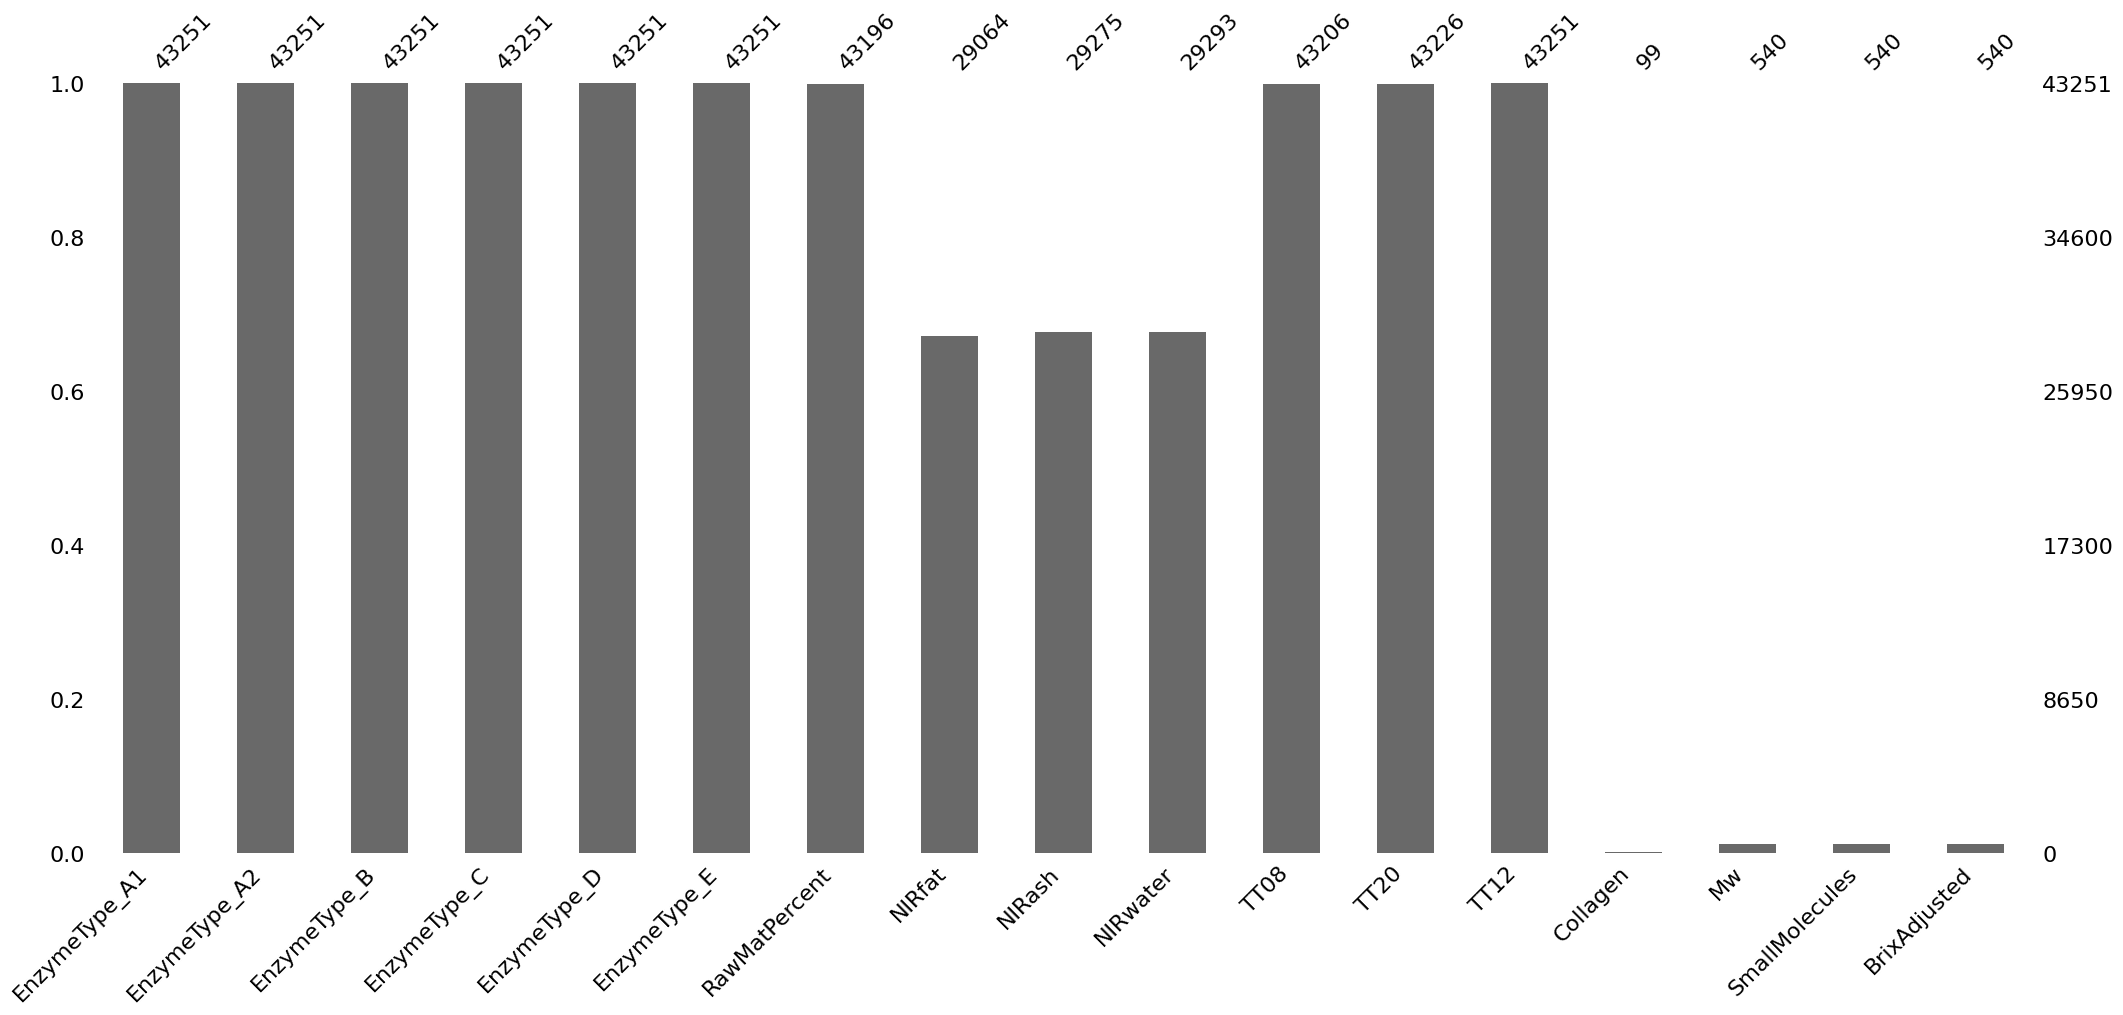

In [6]:
msno.bar(bioco_data)

<Axes: >

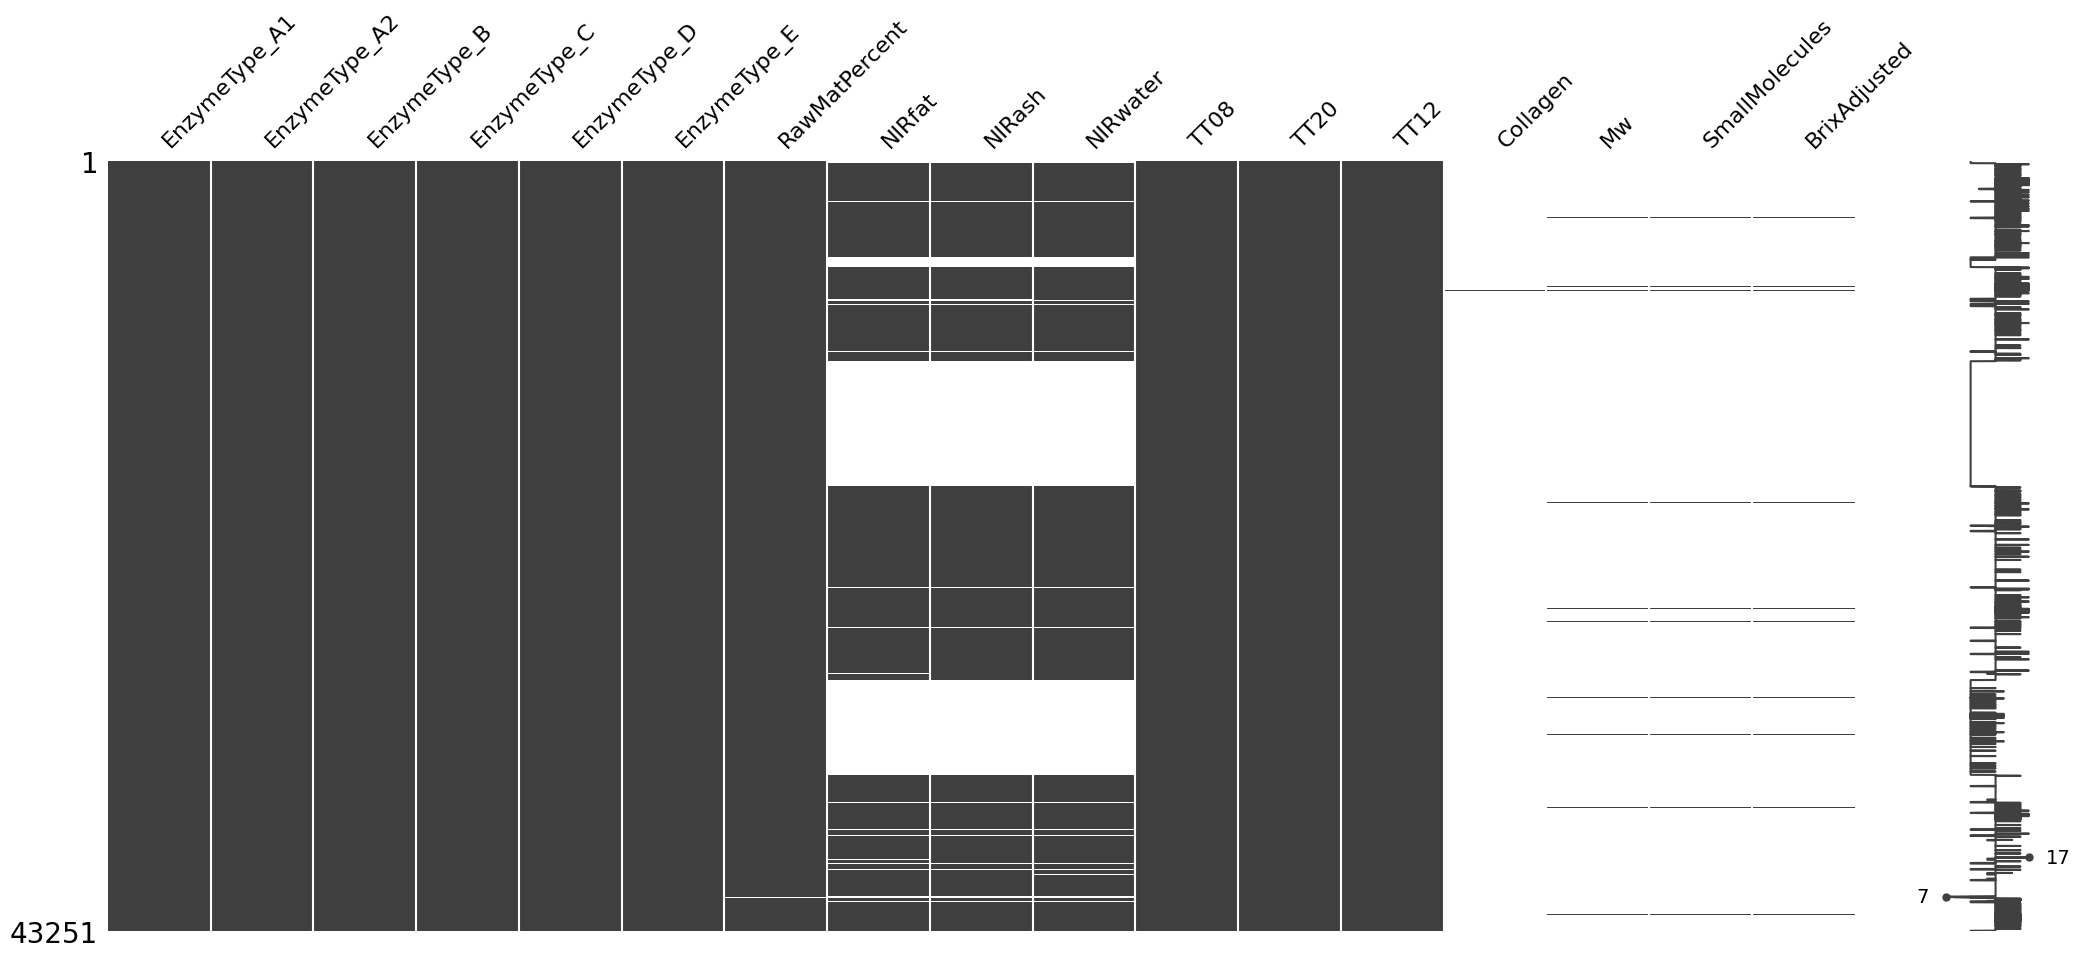

In [7]:
msno.matrix(bioco_data)

Oversikt over og behandling av rader med manglende verdier for RawMatPercent

In [8]:
# Henter ut index til rader med manglende verdier for "RawMatFlow"
rawmat_manglende_index = bioco_data[bioco_data['RawMatPercent'].isnull()].index

# Sjekker hvilke andre kolonner som har manglende verdier for samme rader
bioco_data[rawmat_manglende_index[0]:rawmat_manglende_index[-1]].isnull().sum()

# Dropper de spesifikke rader fra datasett, første 55 rader med data
prosessert_data = bioco_data.drop(bioco_data.loc[rawmat_manglende_index[0]:rawmat_manglende_index[-1]].index)

# Sjekker manglende verdier etter behandling
prosessert_data.isnull().sum()

EnzymeType_A1         0
EnzymeType_A2         0
EnzymeType_B          0
EnzymeType_C          0
EnzymeType_D          0
EnzymeType_E          0
RawMatPercent         0
NIRfat            14132
NIRash            13921
NIRwater          13903
TT08                  0
TT20                  0
TT12                  0
Collagen          43097
Mw                42656
SmallMolecules    42656
BrixAdjusted      42656
dtype: int64

## Behandling av manglende verdier for NIR målinger

### ACF - plot

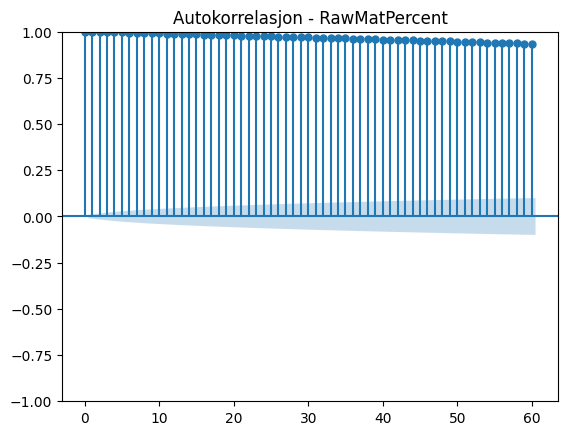

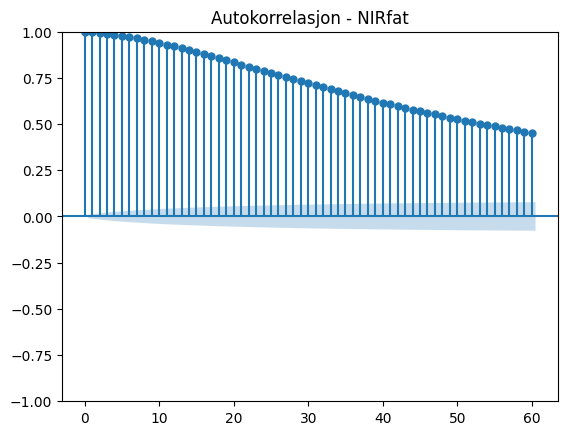

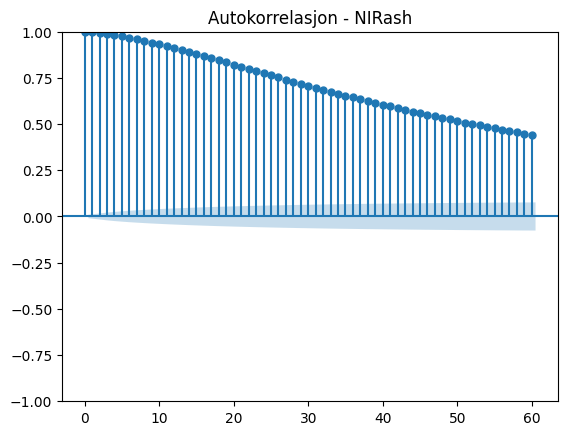

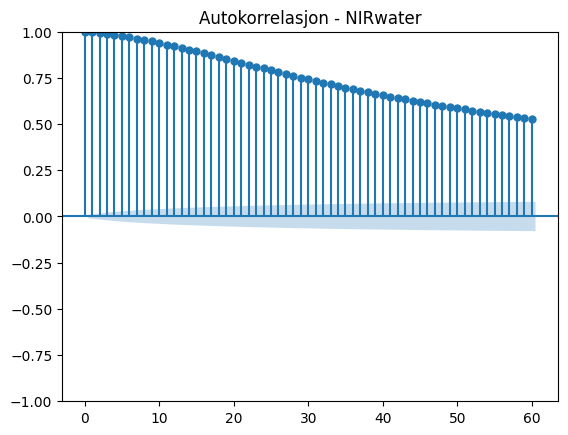

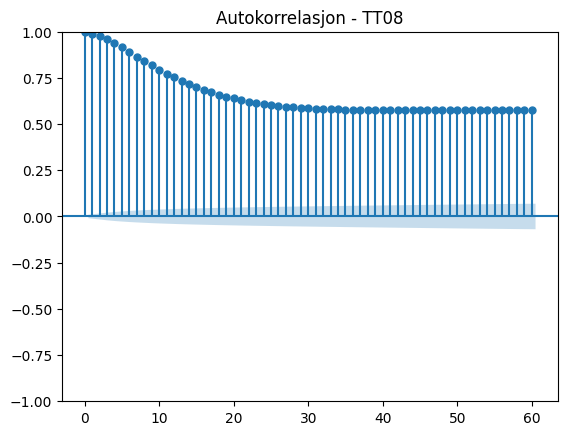

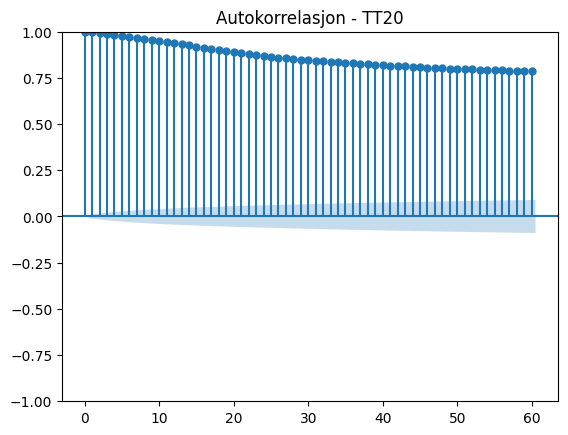

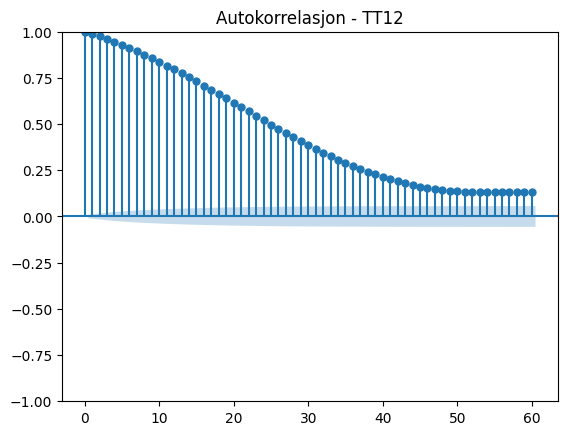

In [9]:
prediktorer = bioco_data.columns[6:-4].to_list()

for prediktor in prediktorer:
  plot_acf(bioco_data[prediktor].values.squeeze(),
           lags=60,
           missing='drop',
           title='Autokorrelasjon - ' + str(prediktor))

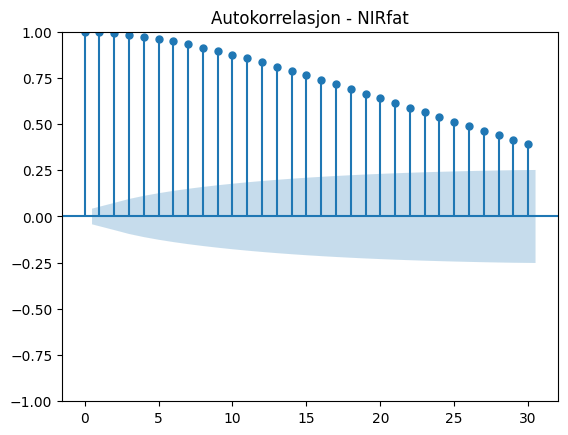

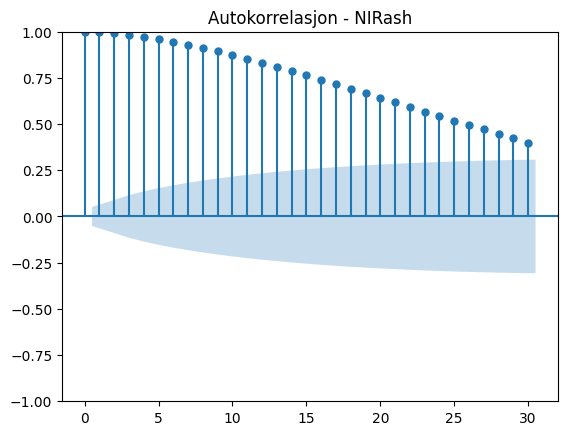

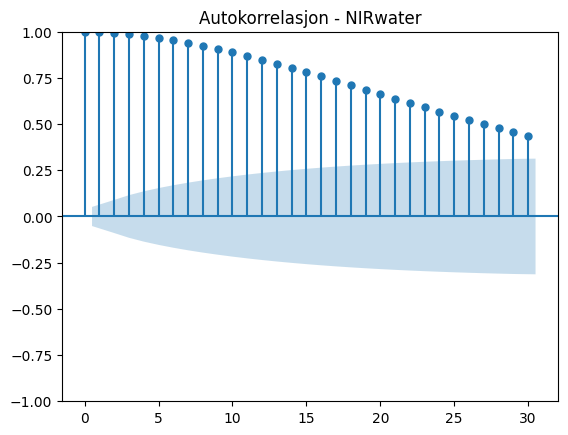

In [10]:
nir_prediktorer = ['NIRfat', 'NIRash', 'NIRwater']

for nir in nir_prediktorer:
  nir_data = bioco_data[nir]
  første_obs = nir_data.notna().argmax()
  nir_data_først = nir_data[første_obs:]

  for i in range(1, len(nir_data_først.index)):

    tidsdiff = nir_data_først.index[i] - nir_data_først.index[i-1]
    if tidsdiff.total_seconds() > 60.0:
      nir_sekvens = nir_data_først.index[i-1]

      nir_data_sekvens = nir_data_først[:nir_sekvens]

      nir_neste_nan = nir_data_sekvens.isna().argmax()
      nir_data_sekvens = nir_data_sekvens[:nir_neste_nan]

      plot_acf(nir_data_sekvens.values.squeeze(),
              lags=30,
              title='Autokorrelasjon - ' + str(nir))
      break

### Dropping av bestemte intervaller med manglende verdier

Oversikt over rader med manglende verdier for NIR-målinger

In [11]:
prosessert_data = håndter_manglende_verdier(prosessert_data, diff_max=15, variabler=['NIRfat', 'NIRwater', 'NIRash'])

132 av 14132 NIRfat målinger som mangler er i kortere intervaller enn 15 min
144 av 204 NIRwater målinger som mangler er i kortere intervaller enn 15 min
148 av 148 NIRash målinger som mangler er i kortere intervaller enn 15 min


# Undersøker gjenværende manglende data etter ekskludering

In [12]:
# Filtrerer ut data for forklaringsvaribler
prediktor_data = prosessert_data.iloc[:, :-4]

# Henter ut data som skal interpoleres
prosessert_data_interpolering = prosessert_data[prediktor_data.isnull().any(axis=1)]

# Antall observasjoner med interpolert data
print(prosessert_data_interpolering.shape[0], 'observasjoner med interpolerte verdier')

# Sjekker om interpolert data inneholder markeriger
print(prosessert_data_interpolering.dropna(subset=['Mw']).shape[0], 'markerte observasjoner med interpolerte verdier')

148 observasjoner med interpolerte verdier
0 markerte observasjoner med interpolerte verdier


## Interpolering av resterende manglende verdier

LOF for behandling av manglende verdier

In [13]:
# Datasett for prediktorer
prediktorer = prosessert_data.iloc[:, :-4].columns

# Går gjennom prediktorer og interpolerer med LOF
for prediktor in prediktorer:
  prosessert_data[prediktor] = prosessert_data[prediktor].fillna(method = 'ffill')

Lagring av data behandlet for manglende verdier som csv

In [14]:
prosessert_data.to_csv('/content/drive/MyDrive/MasterV24/Bioco_data/manglende_data_behandlet_bioco_data.csv')

# Informasjon om data som ble ekskludert i behandlingen

In [15]:
# Finner hvilke rader som er unike og til felles for førbehandlet og behandlet data
samlet_data = bioco_data.merge(prosessert_data, how='left', indicator=True)

# Filtrerer ut data som ikke er tilstede i behandlet datasett
ekskludert_data = samlet_data[samlet_data['_merge'] == 'left_only'].drop(columns='_merge')

# Antall ekskluderte rader
print(ekskludert_data.shape[0], 'rader er ekskludert etter behandling av manglende verdier')

# Antall ekskluderte markerte observasjoner
print(ekskludert_data.dropna(subset=['Collagen']).shape[0],\
      'markerte observasjoner av "Collagen" er ekskludert etter behandling av manglende verdier')

print(ekskludert_data.dropna(subset=['Mw']).shape[0],\
      'markerte observasjoner av andre kvalitetsmålinger er ekskludert etter behandling av manglende verdier')

14263 rader er ekskludert etter behandling av manglende verdier
10 markerte observasjoner av "Collagen" er ekskludert etter behandling av manglende verdier
80 markerte observasjoner av andre kvalitetsmålinger er ekskludert etter behandling av manglende verdier
